# SSD7 Inference with VGG16

We'll do inference of SSD7 on the Computer Vision and Deep Learning `test` dataset, but note that the `Inference` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the inference on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

In [ ]:
# Installation of compatible versions of tensorflow, gast and keras
# Downgrade tensoflow
%tensorflow_version 1.x

# Downgrade gast version 0.2.2
!pip install gast==0.2.2

# Downgrade keras version 2.2.4
!pip install keras==2.2.4

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ad637060a74d9a263a5ff5fe7471a737e5e27fc8463df3b67f55ab16a1c1914c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [ ]:
# Upload the gdrive to use dataset, model and weights
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip '/content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView/Dataset.zip'

# Enter in ssd_keras dir
%cd /content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView

/content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView


In [ ]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from collections import namedtuple
import cv2

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_loss_function.metrics_ssd_loss import SSDLossMetrics
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Set the image size.
img_height = 480
img_width = 640

# Define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. You can then of course save the model and next time load the full model directly, without having to build it. However, we recommend to build the model because the loading is slower and sometimes memory consumption is expensive.

### 1.1. Build the model and load trained weights into it

In [ ]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, 3),
                    n_classes=1,
                    mode='training',  # Change to inference for weights
                    l2_regularization=0.0005,
                    scales=[0.08, 0.16, 0.32, 0.64, 0.96],
                    aspect_ratios_global=[0.5, 1.0, 2.0],
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=True,
                    steps=None,
                    offsets=None,
                    clip_boxes=False,
                    variances=[1.0, 1.0, 1.0, 1.0],
                    normalize_coords=True,
                    subtract_mean=127.5,
                    divide_by_stddev=127.5)

# 2: Load the trained weights into the model.

# Set the path of the trained weights.
weights_path = '/content/drive/My Drive/ssd_keras_model/ssd7_epoch-35.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
ssd_loss_metrics = SSDLossMetrics(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=[ssd_loss_metrics.f1_m,
                                                                   ssd_loss_metrics.iou_m])
















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

In [ ]:
# Set the path to the `.h5` file of the model to be loaded.
model_path = '/content/drive/My Drive/ssd_keras_model/ssd7_cvdata_epoch-16_loss-1.0308_val_loss-0.8069.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,                                              
                                               'compute_loss': ssd_loss.compute_loss})
















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




## 2. Make predictions on CV&DL Test

Let's use a `DataGenerator` to make predictions on the CV&DL test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison.

In [ ]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# Set the paths to the datasets here.

Dataset_CV_images_dir              = '/content/Dataset_CV/ImagesDir/'
Dataset_CV_annotations_dir         = '/content/Dataset_CV/AnnotationsDir/'
Dataset_CV_test_image_set_filename = '/content/Dataset_CV/ImageSet/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background', 'person']

dataset.parse_xml(images_dirs=[Dataset_CV_images_dir],
                  image_set_filenames=[Dataset_CV_test_image_set_filename],
                  annotations_dirs=[Dataset_CV_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)


Processing image set 'test.txt': 100%|██████████| 5082/5082 [00:07<00:00, 687.77it/s]


In [ ]:
generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

# Generate a batch and make predictions.

batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /content/Dataset_CV/ImagesDir/2_330_411_111835-533533.jpg

Ground truth boxes:

[[  1  73 233 197 364]]


In [ ]:
# Predict.

y_pred = model.predict(batch_images)

Choose the decoding of y_pred based on the type of model you have.

Note: read the commented part to understand which to activate and which not.

In [ ]:
confidence_threshold = 0.5

# Perform confidence thresholding.
#y_pred_thresh = [y_pred[k][y_pred[k,:,0] > confidence_threshold] for k in range(y_pred.shape[0])]  # This is for 'inference' mode
y_pred_thresh = decode_detections(y_pred,                                                           # This for 'training' mode
                                  confidence_thresh=0.5,
                                  iou_threshold=0.45,
                                  top_k=200,
                                  img_height=img_height,
                                  img_width=img_width)

# Re-order column to calcolate the IoU
def swap(array):
  array1 = np.zeros(array.shape)
  array1[:,0] = array[:,0]
  array1[:,1] = array[:,2]
  array1[:,2] = array[:,3]
  array1[:,3] = array[:,4]
  array1[:,4] = array[:,5]
  array1[:,5] = array[:,1]
  return array1

y_swap = np.zeros(np.array(y_pred_thresh).shape)
for arr in y_pred_thresh:
  y_swap[i] = swap(y_pred_thresh[i])

# Print the result
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('class   xmin   ymin   xmax   ymax   conf')
print(y_swap[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.    66.31 206.83 199.29 373.07]]


In [ ]:
# Define the bb_intersection_over_union function, which as the name suggests,
# Is responsible for computing the Intersection over Union between two bounding boxes:

# Define the image detections
Detection(batch_images[i], np.array(batch_labels[i]), y_swap[i])
for box in batch_labels[i]:
    xminA = box[1]
    yminA = box[2]
    xmaxA = box[3]
    ymaxA = box[4]

for box in y_swap[i]:
    xminB = box[1]
    yminB = box[2]
    xmaxB = box[3]
    ymaxB = box[4]

# Determine the (x, y)-coordinates of the intersection rectangle
xA = max(xminA, xminB)
yA = max(yminA, yminB)
xB = min(xmaxA, xmaxB)
yB = min(ymaxA, ymaxB)

# Compute the area of intersection rectangle
interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

# Compute the area of both the prediction and ground-truth rectangles
boxAArea = (xmaxA - xminA + 1) * (ymaxA - yminA + 1)
boxBArea = (xmaxB - xminB + 1) * (ymaxB - yminB + 1)

# Compute the intersection over union by taking the intersection
# Area and dividing it by the sum of prediction + ground-truth
# Areas - the interesection area
iou = interArea / float(boxAArea + boxBArea - interArea)
print('IOU', round(iou, 3))

IOU 0.736


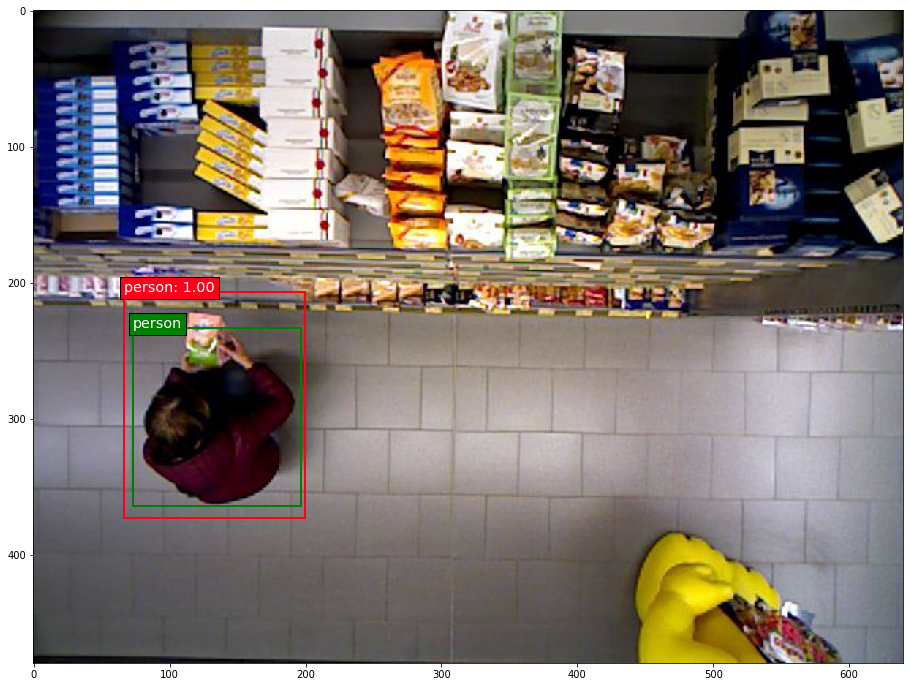

In [ ]:
# Display the image and draw the predicted boxes onto it.
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 2)).tolist()
classes = ['background', 'person']

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_swap[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[5])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})